In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# Updated imports for new modular pipeline
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.denoising_methods.denoisers import EncoderDenoiser  # Updated path
from xasdenoise.denoising_pipeline import PipelineConfig, DenoisingPipeline  # New modular pipeline

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labels

# Load an example dataset
Either load the basic arrays from the csv file. Also we can load the previously created Spectrum object which contains various pre-computed arrays and values. 

Loaded NiMOF74 spectrum.
Loaded 1 spectra from ./data/time_resolved_spectra.h5


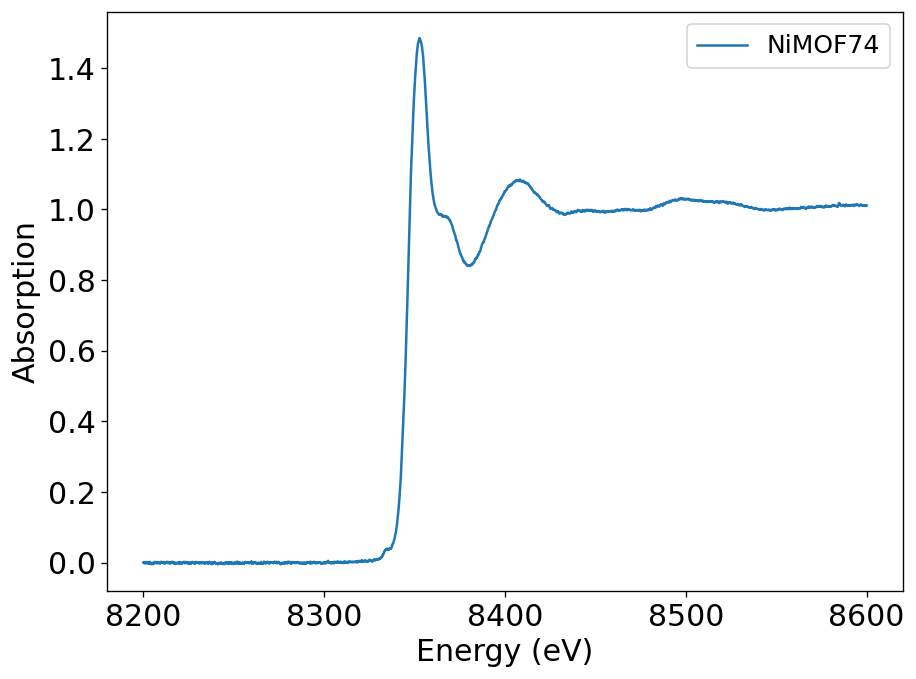

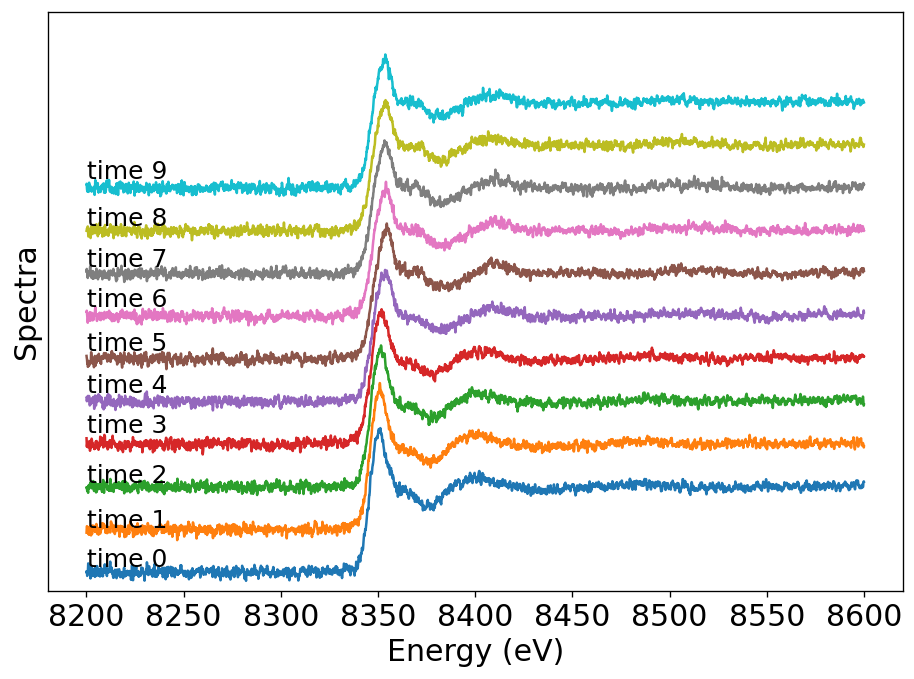

In [2]:
spectrum0 = data_io.load_spectra_from_h5('./data/time_resolved_spectra.h5')

# Visualize
visualization.plot_spectrum(spectrum0, time_averaged=True)
visualization.plot_spectrum_time_instances(spectrum0,vertical_displacement_offset=.5, time_instance_number=10)

# Time resolved data denoising using a noise2noise method
We can assume that the neighboring time instances are very similar to each other (identical) and the main differences are due to random noise variations. This allows using the noise2noise approach to train an autoencoder denoiser using a single time-resolved dataset.

In [3]:
from xasdenoise.xas_data import spectrum, training
import torch
import numpy as np

def create_training_data(spectrum):
    # Initialize the training data
    spectrum_list_train, spectrum_list_target = [spectrum], [spectrum]
    
    # Create training tensors using noise2noise method from neighboring time instances    
    x, y_train, y_target, data_mask, compounds, elements, edges = \
        training.create_training_tensors(spectrum_list_train, spectrum_list_target, 
                                        remove_background=False, warp=False, scale=False, 
                                        noise2noise=True, randomize_times=False)
   
    return x, y_train, y_target, data_mask, compounds, elements, edges

def train_autoencoder(spectrum, num_layers=4, kernel_size=9, dropout_rate=0.1, model='conv', 
                      gpu_index=0, device='auto', epochs=100,
                      model_path='./data/trained_model.pth'):
    
    # Create training data
    x, y_train, y_target, data_mask, compounds, elements, edges = create_training_data(spectrum)

    # Define model type and initialize the denoiser
    denoiser = EncoderDenoiser(model_type=model, device=device, signal_length=y_train.shape[1], gpu_index=gpu_index,
                            num_layers=num_layers,  # Number of layers in the model
                            kernel_size=kernel_size,
                            dropout_rate=dropout_rate)  # Kernel size for convolutional layers

    # Train the model
    training_metrics = denoiser.train_model(
        y_train=y_train,  # Noisy spectra as input
        y_target=y_target,  # Clean spectra as target
        mask_train=data_mask,  # Data mask

        batch_size=8,
        num_epochs=epochs,
        save_path=model_path,  # Save the trained model
        learning_rate=1e-3,
        augment_data=False,  # Whether to augment the data                        
        remove_padded_regions=False,  # Remove padded regions from the data
    )


def denoise_data_noise2noise(spectrum0, train_encoder=False,
                 num_layers=4, kernel_size=31, dropout_rate=0.1,
                 model='conv', 
                 gpu_index=0, device='auto', epochs=100,
                 model_path='./data/trained_model.pth'):
    
    # Spectrum to be denoised
    spectrum = spectrum0.copy()

    # Train the autoencoder using noise2noise for a given time-series dataset
    if train_encoder:
        train_autoencoder(spectrum, num_layers=num_layers, kernel_size=kernel_size, model=model, 
                        gpu_index=gpu_index, device=device, epochs=epochs,
                        model_path=model_path, dropout_rate=0.1)

    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Model was trained with baseline removal
    )
    
    # Load the trained model
    denoiser = EncoderDenoiser(model_type=model, num_layers=num_layers, kernel_size=kernel_size, dropout_rate=dropout_rate)
    denoiser.load_model(model_path)
    
    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum).process(denoiser)
    
    # Load the data into the pipeline, process it, and get the results
    pipeline.load_data(spectrum)    
    pipeline.process()
    denoised_spectrum, error, noise = pipeline.get_results()
    
    # pipeline.plot_results(fig_size=(10, 6))
    visualization.plot_spectrum_time_instances(spectrum,vertical_displacement_offset=.3, time_instance_number=10)
    spectrum.spectrum = denoised_spectrum
    visualization.plot_spectrum_time_instances(spectrum,vertical_displacement_offset=.3, time_instance_number=10)

### Train a noise2noise model on a single time-series dataset and denoise it

Using Apple Silicon MPS device.


Epoch 50/100: 100%|████████████████████| 73/73 [00:01<00:00, 59.31it/s, epoch_loss=0.01012202, best_loss=0.00931232]          


Model saved to ./data/trained_model_checkpoint.pth


Epoch 100/100: 100%|████████████████████| 73/73 [00:01<00:00, 42.00it/s, epoch_loss=0.00952027, best_loss=0.00787516]          


Model saved to ./data/trained_model_checkpoint.pth
Final model saved to ./data/trained_model.pth
Using Apple Silicon MPS device.
Model loaded from ./data/trained_model.pth


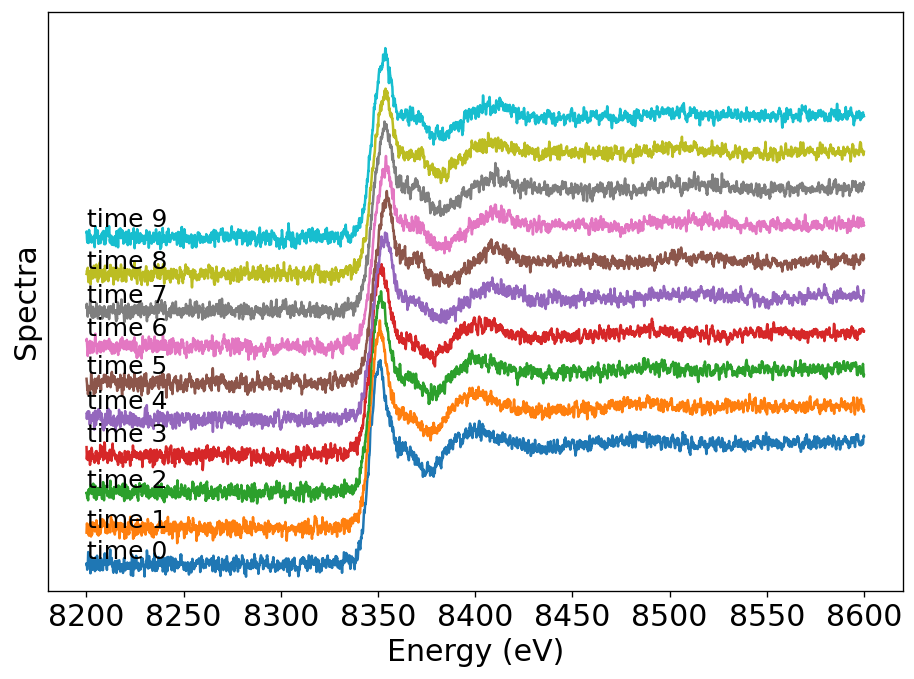

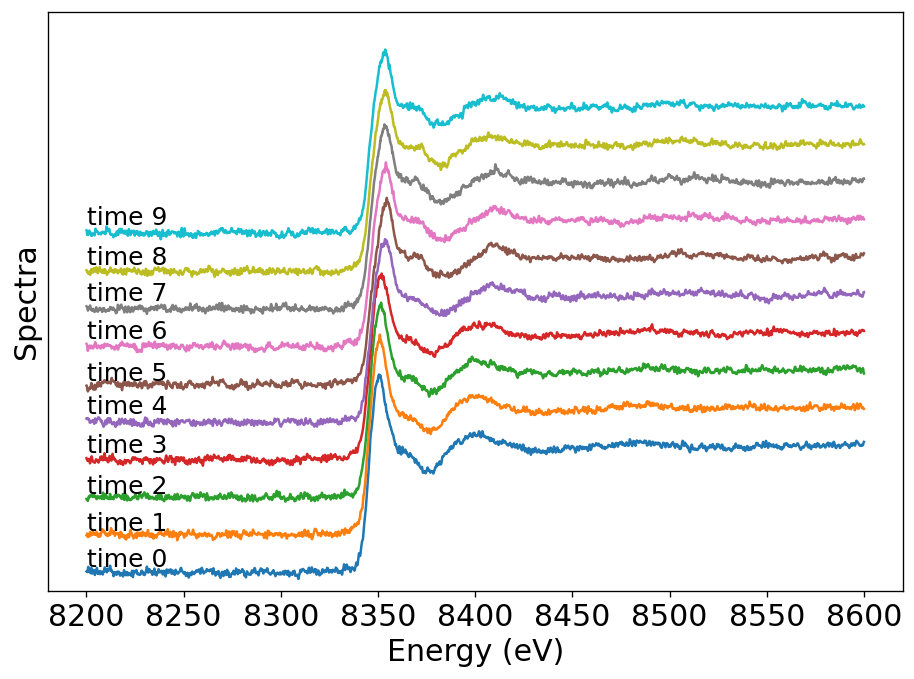

In [4]:
denoise_data_noise2noise(spectrum0, train_encoder=True, num_layers=2, kernel_size=31, dropout_rate=0.1)